### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 17th at 11.59pm CST
---

## Only one problem this week

This problem is mostly about generative classification, but will include one discriminative classifer that we'll meet in `Lecture_20`.

1. Use the following code snippet to read in SDSS galaxy color data.
```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```
This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [102]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.tree import DecisionTreeClassifier

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [103]:
#1
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
print(data.dtype.names)
#print(len(data['specClass']))
ug= data['u']-data['g']
gr= data['g']-data['r']
ri= data['r']-data['i']
iz= data['i']-data['z']
redshift= data['redshift']
spec= data['specClass']
gals= (len(spec[np.where(spec=='GALAXY')]))
print('Number of galaxies = '+str(gals))
print('Number of QSOs= '+str(50000-gals))

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
Number of galaxies = 42832
Number of QSOs= 7168


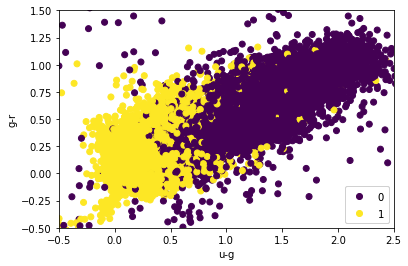

In [104]:
#2
fig, ax = plt.subplots()
specbool=(spec=='QSO')
scatter=ax.scatter(ug,gr,c=specbool,label=spec)
legend1 = ax.legend(*scatter.legend_elements())
ax.add_artist(legend1)
ax.set_xlim(-.5,2.5)
ax.set_ylim(-.5,1.5)
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')
plt.show()

In [105]:
#3
X= np.empty([50000,5])
X[:,0]= ug
X[:,1]= gr
X[:,2]= ri
X[:,3]= iz
X[:,4]= redshift
target = specbool
Xtrain,Xtest,ytrain,ytest= train_test_split(X,target, test_size= .2)

[False  True]
[False  True]
[False  True]
[False  True]


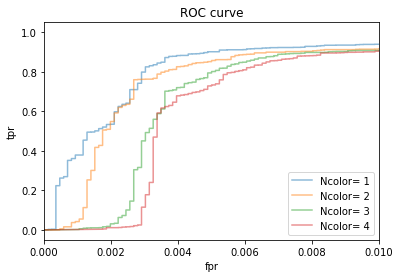

In [106]:
#4
#using this method from the lecture notebook
for i in range(4):
    clf = GaussianNB()
    clf.fit(Xtrain[:, :i+1], ytrain)
    print(clf.classes_)
    
    # Gives the probability for both classes, take quasar class
    y_prob = clf.predict_proba(Xtest[:, :i+1])[:,1]
    
    fpr, tpr, thresh = roc_curve(ytest, y_prob) 
    plt.plot(fpr, tpr,alpha=0.5,label='Ncolor= '+str(i+1))
    
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.xlim(0,0.01)
plt.legend()
plt.show()

#Only examining one color results in the highest true positive rate for a given false positive rate

SRT: It does if you only examine colors, but redshift is also part of your data matrix, and it makes the classification accuracy very high by itself and when included with colors. Your "for" loop didn't go up to large enough values to include the redshift. -2

[False  True]
[False  True]
[False  True]
[False  True]


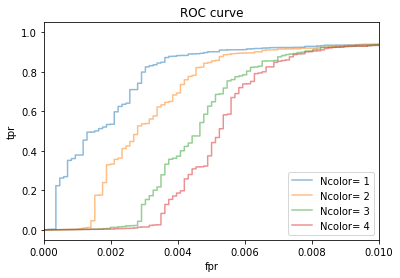

In [107]:
#5
for i in range(4):
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(Xtrain[:, :i+1], ytrain)
    print(clf.classes_)
    
    # Gives the probability for both classes, take quasar class
    y_prob = clf.predict_proba(Xtest[:, :i+1])[:,1]
    
    fpr, tpr, thresh = roc_curve(ytest, y_prob) 
    plt.plot(fpr, tpr,alpha=0.5,label='Ncolor= '+str(i+1))
    
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.xlim(0,0.01)
plt.legend()
plt.show()

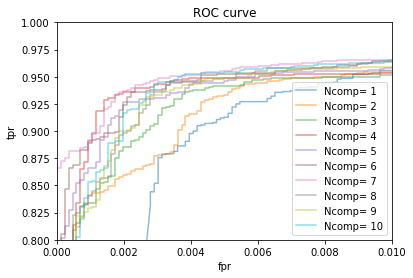

In [108]:
#6
ncomp= np.arange(1,11)
for n in ncomp:
    clf = GMMBayes(n)
    clf.fit(Xtrain, ytrain)
    y_prob = clf.predict_proba(Xtest)[:,1]
    fpr, tpr, thresh = roc_curve(ytest, y_prob) 
    plt.plot(fpr, tpr,alpha=0.5,label='Ncomp= '+str(n))

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.xlim(0,0.01)
plt.ylim(.8,1)
plt.legend()
plt.show()
# the 9 component model seems to max out on completeness the fastest

SRT: How are you judging this? The area under the ROC curve is a sure-fire way to put a number to this. By eye is difficult -1

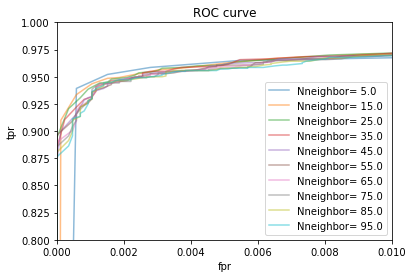

In [109]:
#7
nn= np.linspace(5,95,10)
for n in nn:
    clf = KNeighborsClassifier(int(n))
    clf.fit(Xtrain, ytrain)
    y_prob = clf.predict_proba(Xtest)[:,1]
    fpr, tpr, thresh = roc_curve(ytest, y_prob) 
    plt.plot(fpr, tpr,alpha=0.5,label='Nneighbor= '+str(n))

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.xlim(0,0.01)
plt.ylim(.8,1)
plt.legend()
plt.show()
#the 15 neighbor model seems to edge out the 5 neighbor model for max completeness at the same efficiency

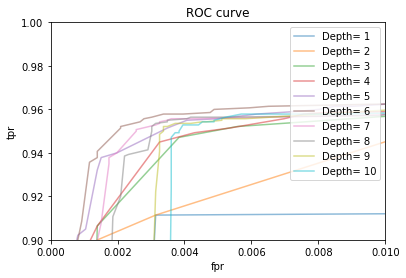

In [110]:
#8
depth= np.arange(1,11)
for n in depth:
    clf = DecisionTreeClassifier(max_depth=n)
    clf.fit(Xtrain, ytrain)
    y_prob = clf.predict_proba(Xtest)[:,1]
    fpr, tpr, thresh = roc_curve(ytest, y_prob) 
    plt.plot(fpr, tpr,alpha=0.5,label='Depth= '+str(n))
    
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.xlim(0,0.01)
plt.ylim(0.9,1)
plt.legend()
plt.show()
#I zoomed in pretty far bc it was kinda close but I think I'm gonna go with a max depth of 6

SRT: Agreed!

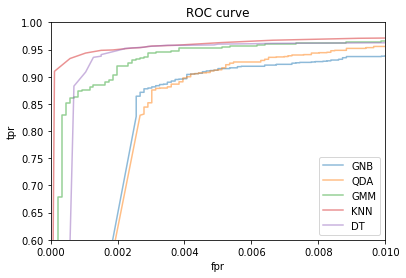

In [111]:
#9
clf1 = GaussianNB()
clf1.fit(Xtrain, ytrain)
clf2 = QuadraticDiscriminantAnalysis()
clf2.fit(Xtrain,ytrain)
clf3 = GMMBayes(9)
clf3.fit(Xtrain,ytrain)
clf4 = KNeighborsClassifier(15)
clf4.fit(Xtrain,ytrain)
clf5= DecisionTreeClassifier(max_depth=6)
clf5.fit(Xtrain,ytrain)

y_prob1 = clf1.predict_proba(Xtest)[:,1]
fpr1, tpr1, thresh1 = roc_curve(ytest, y_prob1) 
y_prob2 = clf2.predict_proba(Xtest)[:,1]
fpr2, tpr2, thresh2 = roc_curve(ytest, y_prob2) 
y_prob3 = clf3.predict_proba(Xtest)[:,1]
fpr3, tpr3, thresh3 = roc_curve(ytest, y_prob3) 
y_prob4 = clf4.predict_proba(Xtest)[:,1]
fpr4, tpr4, thresh4 = roc_curve(ytest, y_prob4) 
y_prob5 = clf5.predict_proba(Xtest)[:,1]
fpr5, tpr5, thresh5 = roc_curve(ytest, y_prob5) 


plt.plot(fpr1, tpr1,alpha=0.5,label='GNB')
plt.plot(fpr2, tpr2,alpha=0.5,label='QDA')
plt.plot(fpr3, tpr3,alpha=0.5,label='GMM')
plt.plot(fpr4, tpr4,alpha=0.5,label='KNN')
plt.plot(fpr5, tpr5,alpha=0.5,label='DT')

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.xlim(0,0.01)
plt.ylim(0.6,1)
plt.legend()
plt.show()

#K nearest neighbors seems to be the best for this purpose

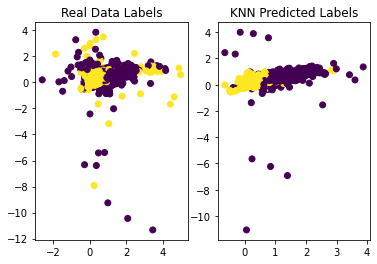

In [113]:
#10
Kpredict= clf4.predict(Xtest)
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(Xtrain[:,0],Xtrain[:,1],c=ytrain)
ax1.set_title('Real Data Labels')
ax2.scatter(Xtest[:,0],Xtest[:,1],c=Kpredict)
ax2.set_title('KNN Predicted Labels')

plt.show()

SRT: Excellent work!